# RAVE Model Training: Donald Trump's Voice Simulator

These are the project codes used in my practice to train a voice transfer model based on the real-time audio Variational autoencoder (RAVE) model published by Antoine Caillon and Philippe Esling [1], using a custom dataset of Donald Trump’s public speech audio files.

In this notebook file, I will test the performance of the RAVE models, including unconditional generation (generating from latent z with the decoder) and timbre transfer (passing existing audio through the encoder and decoder model to alter the timbre of the sound), and evaluate two versions of the models that with different number of epochs trained, with analysing and comparing amplitude, STFT, cosine distance and SNR.

The codes used in this file are adapted from the AI for Media: Week6 course notebook file [2]. 

The code source used for training can be found at: https://colab.research.google.com/drive/1ih-gv1iHEZNuGhHPvCHrleLNXvooQMvI?usp=sharing

**Note:** The generated data will be slightly different each time this notebook runs. The current graphs are the original ones used in my work analysis, please refer those to the report before making a run of the codes.

### Libraries Required

Uncomment and run the below code block to install the packages if haven't done so.

In [ ]:
# !pip install --quiet wget
# !pip install --quiet acids-rave # --quiet avoids long outputs. if you get any errors, remove --quiet
# !yes|conda install ffmpeg
# !pip install torch torchvision torchaudio

### Import the Packages

In [1]:
import os
import torch

import numpy as np
import librosa as li
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

from scipy import signal

### Load the Model

In [2]:
pt_path = "../AI-4-Media/rave_models"

generated_path = "../AI-4-Media/rave_models/generated" # folder where generated audio will be saved
if not os.path.exists(generated_path): # create the folder if it doesn't exist
    os.mkdir(generated_path)

#load the model
pretrained_model = "model_1037"  #this is the model trained with 1037 epochs, the current best model
model = torch.jit.load(f"{pt_path}/{pretrained_model}.ts" ).eval()  #set the model to evaluation mode
torch.set_grad_enabled(False) #disable gradients calculation

#define the sample rate hyperparameter
sample_rate = 44100 # sample rate of the audio

### Random generation

Here is a random generated audio clip from the model. Although not that clear, some of the human-speech like piece can still be percepted.

In [5]:
generated_clips = []

for i in range(100):
    #Randomly sample latent space
    z = torch.randn(1,16,1)
    
    # Generate audio clip and append to list
    gen_audio_clip = model.decode(z)    #decode the latent variable z to audio using the model
    gen_audio_clip = gen_audio_clip.reshape(-1).cpu().numpy()   #reshape the audio to 1D array
    generated_clips.append(gen_audio_clip)  #add the audio piece to the list

# Concatonate list of audio clips into one array
generated_audio = np.concatenate(generated_clips)
ipd.display(ipd.Audio(data=generated_audio, rate=sample_rate)) #display audio widget

### Load an Audio File as the Example to be Transferred

A female voice saying: "Come on, talk to me, talk to me, say something!"

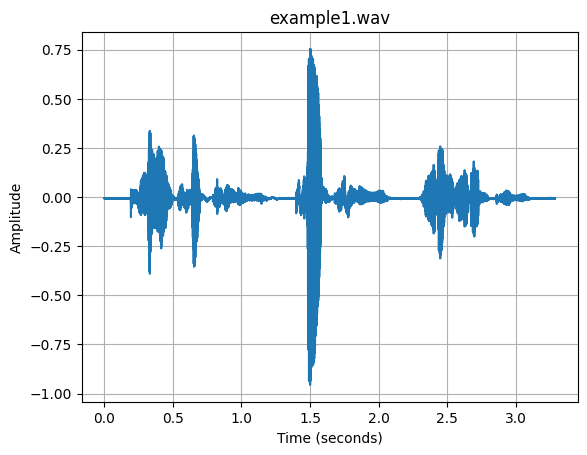

In [4]:
input_file = "../AI-4-Media/media/sounds/example1.wav"   #audio file downloaded from https://freesound.org/people/deleted_user_1390811/sounds/86400/
input_data = li.load(input_file, sr=sample_rate)[0] # load input audio

time = np.arange(0, len(input_data))/sample_rate  #divide the sample index by the sample rate to obtain the time in seconds

#plot the sound wave graph
plt.plot(time,input_data)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(input_file.split("/")[-1])
plt.grid()

ipd.display(ipd.Audio(data=input_data, rate=sample_rate))

### Perform voice transfer 

Based on RAVE's timbre transfer method, let's take the female audio and try transferring it to the voice of Donald Trump, using the model trained with 1037 epochs.

In [31]:
x = torch.from_numpy(input_data).reshape(1, 1, -1)  #convert audio to tensor and add batch and channel dimensions
z = model.encode(x)  #encode audio into latent representation

print(z.shape)
#synthesize audio from latent representation
y = model.decode(z).numpy()  #decode latent representation and convert tensor to numpy array
y = y[:,0,:].reshape(-1)  #remove batch and channel dimensions
y = y[abs(len(input_data)- len(y)):]  #trim to match input length as somehow the output is a bit longer than the input

#save the output
output_file =f'{generated_path}/{input_file.replace(".wav", f"_{pretrained_model}_generated.wav").split("/")[-1]}'
sf.write(output_file,y, sample_rate)

ipd.Audio(output_file)

torch.Size([1, 16, 71])


The above code was used to produce the transfered speech. Since each re-run of the above code will make the generation slightly different, below provides the audio version that was used for the analysis works, generated by the '1037 model' (trained after 1037 epochs).

In [5]:
audio_path1 = "../AI-4-Media/rave_models/generated/example1_model_1037_generated_copy.wav"
ipd.Audio(audio_path1)

Compare the sound wave and spectogram of orignal audio and transferred audio using the amplitude graph and the STFT (Short-Time Fourier Transform) graph: 

C:\Users\tobys\AppData\Local\Temp\ipykernel_1324\731861198.py:16: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  axs[0,1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100,:],
C:\Users\tobys\AppData\Local\Temp\ipykernel_1324\731861198.py:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  axs[1,1].pcolormesh(t2, f2[:100], np.abs(li.amplitude_to_db(Zxx2[:100,:],


Text(0, 0.5, 'Frequency (Hz)')

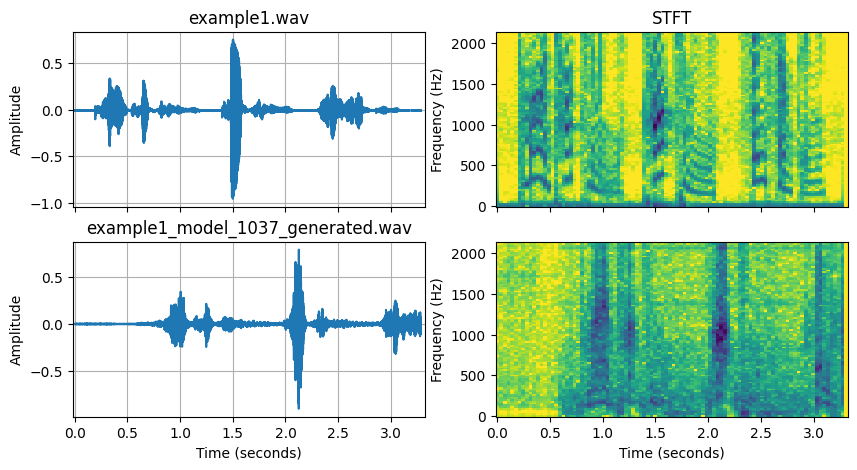

In [15]:
#calculate the STFT of the input and output audio
f1, t1, Zxx1 = signal.stft(input_data, fs=sample_rate, nperseg=2048, noverlap=512)
f2, t2, Zxx2 = signal.stft(y, fs=sample_rate, nperseg=2048, noverlap=512)

fig, axs = plt.subplots(2, 2,figsize=(10,5), sharex=True)

axs[0,0].plot(time,input_data)
axs[0,0].set_ylabel("Amplitude")
axs[0,0].grid()
axs[0,0].set_title(input_file.split("/")[-1])
axs[1,0].plot(time,y)
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_xlabel("Time (seconds)")
axs[1,0].grid()
axs[1,0].set_title(output_file.split("/")[-1])

#plot the STFT power
axs[0,1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100,:],
                                                       ref=np.max)))
axs[1,1].pcolormesh(t2, f2[:100], np.abs(li.amplitude_to_db(Zxx2[:100,:],
                                                       ref=np.max)))
axs[1,1].set_xlabel("Time (seconds)")
axs[0,1].set_title("STFT")
axs[0,1].set_ylabel("Frequency (Hz)")
axs[1,1].set_ylabel("Frequency (Hz)")


### Load an older version of the model (with 200 epochs trained)

In [35]:
pretrained_model_old = "model_202" # select the pretrained model to use

model_old = torch.jit.load(f"{pt_path}/{pretrained_model_old}.ts" ).eval() 
torch.set_grad_enabled(False) # disable gradients

The output this time sounds with a worse quality than the one above, as the noise level seem to be higher and the clearness of human speech is less.

In [37]:
x = torch.from_numpy(input_data).reshape(1, 1, -1) # convert audio to tensor and add batch and channel dimensions
z = model_old.encode(x) # encode audio into latent representation

# synthesize audio from latent representation
y2 = model_old.decode(z).numpy() # decode latent representation and convert tensor to numpy array
y2 = y2[:,0,:].reshape(-1) # remove batch and channel dimensions
y2 = y2[abs(len(input_data)- len(y2)):] # trim to match input length --> for some reason the output is a bit longer than the input

# save output audio
output_file2 =f'{generated_path}/{input_file.replace(".wav", f"_{pretrained_model_old}_generated.wav").split("/")[-1]}'
sf.write(output_file2,y2, sample_rate)

ipd.Audio(output_file2) # display audio widget

Still, below is the actual version used for the analysis work for the '202 model'.

In [6]:
audio_path2 = "../AI-4-Media/rave_models/generated/example1_model_202_generated_copy.wav"
ipd.Audio(audio_path2)

### Anything similar to Trump's voice?

Below is an example of the training data - from Donald Trump's past public speeches:

"...we would consider negotiating with the rest, either individually, or perhaps as a group."

In [128]:
#Trump's voice sounds like this:
exp, sample_rate = li.load('../AI-4-Media/media/sounds/trump_example.wav')
ipd.display(ipd.Audio(data=exp, rate=sample_rate)) # display audio widget

Well, the similarity level seem not to be very satisfied, but remember the models I used only finished little training epochs. Anyway, next, let's find out some statistical evidences that the model's performance could get better with more epochs trained.

### Analyse the two models' outputs, which one is better?

C:\Users\tobys\AppData\Local\Temp\ipykernel_1324\739049252.py:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  axs[0,1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100,:],
C:\Users\tobys\AppData\Local\Temp\ipykernel_1324\739049252.py:20: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  axs[1,1].pcolormesh(t2, f2[:100], np.abs(li.amplitude_to_db(Zxx2[:100,:],


Text(0, 0.5, 'Frequency (Hz)')

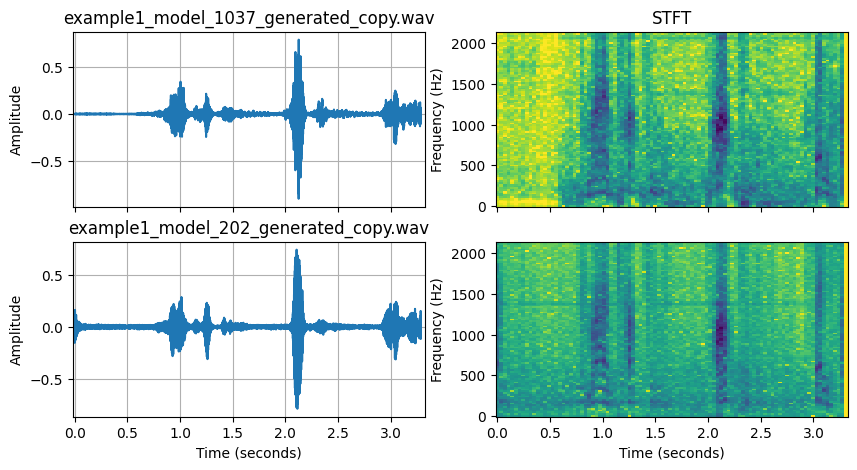

In [25]:
#compare the two models' output, using the 'copy' audio (to redo the work in my analysis process) 

f1, t1, Zxx1 = signal.stft(y, fs=sample_rate, nperseg=2048, noverlap=512)
f2, t2, Zxx2 = signal.stft(y2, fs=sample_rate, nperseg=2048, noverlap=512)

fig, axs = plt.subplots(2, 2,figsize=(10,5), sharex=True)

axs[0,0].plot(time,y)
axs[0,0].set_ylabel("Amplitude")
axs[0,0].grid()
axs[0,0].set_title(audio_path1.split("/")[-1])
axs[1,0].plot(time,y2)
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_xlabel("Time (seconds)")
axs[1,0].grid()
axs[1,0].set_title(audio_path2.split("/")[-1])

axs[0,1].pcolormesh(t1, f1[:100], np.abs(li.amplitude_to_db(Zxx1[:100,:],
                                                       ref=np.max)))
axs[1,1].pcolormesh(t2, f2[:100], np.abs(li.amplitude_to_db(Zxx2[:100,:],
                                                       ref=np.max)))
axs[1,1].set_xlabel("Time (seconds)")
axs[0,1].set_title("STFT")
axs[0,1].set_ylabel("Frequency (Hz)")
axs[1,1].set_ylabel("Frequency (Hz)")

### Compare the models using cosine distance calculation

The below code calculates the cosine distance between the generated audio and the original audio. The output number reflects the distance, and a smaller number here means a shorter cosine distance and higher similarity.

In [3]:
#codes referenced from: https://blog.51cto.com/u_16175453/9024884 

#for the 1037 model:
from scipy.spatial.distance import cosine

audio1, sr1 = li.load('../AI-4-Media/rave_models/generated/example1_model_1037_generated_copy.wav')
audio2, sr2 = li.load('../AI-4-Media/media/sounds/trump_example.wav')

#make sure the two audios have the same length
min_length = min(len(audio1), len(audio2))
audio1 = audio1[:min_length]
audio2 = audio2[:min_length]

#generate MFCC features for both audio signals using librosa.feature.mfcc
mfcc1 = li.feature.mfcc(y=audio1, sr=sr1)
mfcc2 = li.feature.mfcc(y=audio2, sr=sr2)


#transfer the mfcc features to 1D array, referenced from: https://www.w3resource.com/numpy/manipulation/ndarray-flatten.php
distance = cosine(mfcc1.flatten(), mfcc2.flatten())
print("The cosine distance between the two audio files is:", distance)

The cosine distance between the two audio files is: 0.14833098649978638


In [4]:
#for the 202 model:

audio1, sr1 = li.load('../AI-4-Media/rave_models/generated/example1_model_202_generated_copy.wav')
audio2, sr2 = li.load('../AI-4-Media/media/sounds/trump_example.wav')

#make sure the two audios have the same length
min_length = min(len(audio1), len(audio2))
audio1 = audio1[:min_length]
audio2 = audio2[:min_length]

#generate MFCC features for both audio signals using librosa.feature.mfcc
mfcc1 = li.feature.mfcc(y=audio1, sr=sr1)
mfcc2 = li.feature.mfcc(y=audio2, sr=sr2)

distance = cosine(mfcc1.flatten(), mfcc2.flatten())
print("The cosine distance between the two audio files is:", distance)

The cosine distance between the two audio files is: 0.14986556768417358


### SNR (Signal-to-Noise Ratio)

The logic here is to set the audio generated by the model trained with 1037 steps as the ‘signal’, and the audio from the other model will be the ‘noise’, then get the average signal and noise rate and calculate the SNR. 

In [13]:
#codes referenced from: https://blog.51cto.com/u_16175453/7407225?articleABtest=0

#calculate SNR based on the SNR = 10*log10(P_signal/P_noise) formula
#the channel was already set to 1 for the models in the training
def snr_calc(audio1, audio2):
    
    #get the average signal and noise rate and calculate the SNR
    signal = np.sum(audio1**2)/len(audio1)
    noise = np.sum((audio1 - audio2)**2)/len(audio1)
    
    snr = 10*np.log10(signal/noise)  
    return snr

audio1, sr1 = li.load('../AI-4-Media/rave_models/generated/example1_model_1037_generated_copy.wav')
audio2, sr2 = li.load('../AI-4-Media/rave_models/generated/example1_model_202_generated_copy.wav')

snr_score = snr_calc(audio1, audio2)
print("SNR is:", snr_score, " dB")


SNR is: -2.0994979455624962  dB


Since we got a negative number here, it means the noise is stronger than the actual signal. In the calculation we have specified to use audio1 (audio generated by the model with 1037 epochs trained) - audio2 (audio generated by the model with 1037 epochs trained), we can see the less trained model ouputs a worse outcome due to higher noise level.

In general, while the quality of the generated audios is still not close to satisfaction, it is proven that the model trained with more epochs can generate audio more similar to the voice of Donald Trump with less noise level. 

### References

[1] Caillon, A et al. (2023). RAVE: Realtime Audio Variational autoEncoder [online] GitHub. Available at: https://github.com/acids-ircam/RAVE [Accessed March 7 2024].

[2] Broad, T. (2024). Week-6b-Audio-generation/01-audio-generation-with-rave.ipynb [online] GitHub. Available at: https://git.arts.ac.uk/tbroad/AI-4-Media-23-24/blob/main/Week-6b-Audio-generation/01-audio-generation-with-rave.ipynb [Accessed March 9 2024].
